# Задача

ДЗ делаем по бд orders

В качестве ДЗ сделаем карту поведения пользователей.

Мы обсуждали, что всех пользователей можно разделить, к примеру, на 
- !New (совершили только 1 покупку), 
- Regular (совершили 2 или более на сумму не более стольки-то), 
- Vip (совершили дорогие покупки и достаточно часто), 
- ! Lost (раньше покупали хотя бы раз и с даты последней покупки прошло больше 3 месяцев).

Вся база должна войти в эти гурппы (т.е. каждый пользователь должен попадать только в одну из этих групп).

Задача:
1. Уточнить критерии групп New,Regular,Vip,Lost
2. По состоянию на 1.01.2017 понимаем, кто попадает в какую группу, подсчитываем кол-во пользователей в каждой.
3. По состоянию на 1.02.2017 понимаем, кто вышел из каждой из групп, а кто вошел.
4. Аналогично смотрим состояние на 1.03.2017, понимаем кто вышел из каждой из групп, а кто вошел.
5. В итоге делаем вывод, какая группа уменьшается, какая увеличивается и продумываем, в чем может быть причина.

Присылайте отчет в pdf
*/

# Подготовка

## Подключение библиотек

In [1]:
import pymysql.cursors
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import getpass

## Подключение к базе данных

In [2]:
# password_mysql = getpass.getpass(prompt="Введите пароль от MySQL-сервера: ")
password_mysql = "pass123"
mydb = pymysql.connect(host="127.0.0.1",
                             user='root',
                             password=password_mysql, 
                             db='db_analyt_loc',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
 
print ("connect successful!!")

connect successful!!


In [30]:
def show_tables():
    return pd.read_sql("""SHOW TABLES FROM db_analyt_loc;""", con=mydb)
show_tables()

,Tables_in_db_analyt_loc
0,orders_20190822
1,orders_all
2,time_user_b
3,time_user_ym_s
4,users_for_merg


1. Уточнить критерии групп New,Regular,Vip,Lost


## 2. По состоянию на 1.01.2017 понимаем, кто попадает в какую группу, подсчитываем кол-во пользователей в каждой.

In [90]:
current_db = 'orders_20190822'

In [91]:
date = ['\'2017-01-01\'','\'2017-02-01\'']

In [97]:
%%time
df = pd.read_sql(
    f"""
    SELECT
      *, DATE({date[0]}) AS date
    FROM (
    SELECT 
        user_id,
        TIMESTAMPDIFF(MONTH,MAX(o_date),DATE('2017-12-31')) AS period_from_last_ord,
      ROUND(COUNT(id_o)/TIMESTAMPDIFF(DAY,MIN(o_date),MAX(o_date)),0) AS freq,
      ROUND(AVG(price),2) as avg_price,
      COUNT(id_o) AS orders_per_user
    FROM (SELECT * FROM {current_db} WHERE o_date < {date[0]}) AS o2
    GROUP BY user_id) AS t;
    """, con=mydb)
df.shape

Wall time: 17.8 s


(445092, 6)

In [98]:
%%time
df_2 = pd.read_sql(
    f"""
    SELECT
      *, DATE({date[1]}) AS date
    FROM (
    SELECT 
        user_id,
        TIMESTAMPDIFF(MONTH,MAX(o_date),DATE('2017-12-31')) AS period_from_last_ord,
      ROUND(COUNT(id_o)/TIMESTAMPDIFF(DAY,MIN(o_date),MAX(o_date)),0) AS freq,
      ROUND(AVG(price),2) as avg_price,
      COUNT(id_o) AS orders_per_user
    FROM (SELECT * FROM {current_db} WHERE o_date < {date[1]}) AS o2
    GROUP BY user_id) AS t;
    """, con=mydb)
df.shape

Wall time: 19.9 s


(445092, 6)

In [99]:
df = df.append(df_2, ignore_index=True)

---

In [130]:
df['freq']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925924 entries, 0 to 925923
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               925924 non-null  int64         
 1   period_from_last_ord  925924 non-null  int64         
 2   freq                  196225 non-null  float64       
 3   avg_price             925924 non-null  float64       
 4   orders_per_user       925924 non-null  int64         
 5   date                  925924 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 42.4 MB


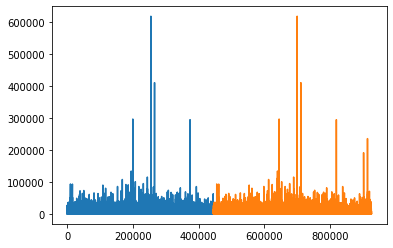

In [137]:
df[df['date'] == '2017-01-01'].avg_price.plot()
df[df['date'] == '2017-02-01'].avg_price.plot();

In [111]:
df['date'] = pd.to_datetime(df['date'])

In [133]:
df.head()

,user_id,period_from_last_ord,freq,avg_price,orders_per_user,date
0,337544,13,0.0065,1243.55,2,2017-01-01
1,171642,13,0.0671,951.62,22,2017-01-01
2,260596,13,0.0276,588.54,9,2017-01-01
3,1105609,23,NaN,752.50,1,2017-01-01
4,982696,23,NaN,4410.00,1,2017-01-01


In [114]:
df.describe()

,user_id,period_from_last_ord,freq,avg_price,orders_per_user
count,9.259240e+05,925924.000000,196225.000000,925924.000000,925924.000000
mean,1.702465e+06,15.485669,0.173906,2203.869145,1.942748
std,7.407655e+05,3.614381,0.494929,3210.207586,8.454946
min,0.000000e+00,11.000000,0.005100,0.000000,1.000000
25%,1.249336e+06,12.000000,0.021700,785.400000,1.000000
50%,1.730607e+06,14.000000,0.041300,1417.500000,1.000000
75%,2.296420e+06,18.000000,0.090900,2517.900000,1.000000
max,3.039754e+06,23.000000,40.000000,616994.000000,1740.000000


### 2. За январь 2017 смотрим, какое кол-во юзеров из п.1 купило в каждой группе и на какую сумму за месяц.(скрипты вам должны помочь)

### 3. Подсчитываем вероятность перехода в покупающего по каждой группе и ср траты за январь в группе (как на занятии).

### 4. В идеале сделать тоже самое на февраль, март, и до конца 17 года (чтобы оценить сезонность и рост трат за месяц)

In [ ]:
%%time
mydb.cursor().execute(
    """
    CREATE TABLE time_user_ym_s
    SELECT
      user_id,
      DATE_FORMAT(o_date, '%y%m') AS ym,
      SUM(price) AS s
    FROM orders_20190822 o
    GROUP BY user_id, DATE_FORMAT(o_date, '%y%m');
    """
)
mydb.commit()

In [ ]:
pd.read_sql(f"SELECT * FROM time_user_ym_s", con=mydb)

# Закрытие сессии

In [ ]:
mydb.close()